In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 9.66MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read data 
with open(SONNETS_FILE) as f:
  data = f.read()

corpus = data.lower().split('\n')

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])


There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


# Tokenizing text

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
total_words

3211

# Generating n_grams

In [5]:
def n_gram_seqs(corpus, tokenizer):
  input_sequences = []
  for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:1+i]
      input_sequences.append(n_gram_sequence)
  return input_sequences


In [6]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [7]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


# Add padding to the sequences

In [8]:
def pad_seqs(input_sequences, maxlen):
  padded_sequences = pad_sequences(input_sequences, maxlen=maxlen)
  return padded_sequences

In [9]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [10]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)
input_sequences.shape

(15462, 11)

# Split the data into features and labels

In [11]:
def features_and_labels(input_sequences, total_works):
  features = input_sequences[:,:-1]
  labels = input_sequences[:,-1]
  one_hot_labels = to_categorical(labels, num_classes=total_works)
  return features, one_hot_labels

In [12]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [13]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)
print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


# Create model

In [14]:
def create_model(total_words, max_sequence_len):
  model = Sequential()
  model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
  model.add(Bidirectional(LSTM(150)))
  model.add(Dense(total_words, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [15]:
model = create_model(total_words, max_sequence_len)

history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 21s 22ms/step - loss: 6.8836 - accuracy: 0.0262
Epoch 2/50
484/484 [==============================] - 5s 11ms/step - loss: 6.4059 - accuracy: 0.0325
Epoch 3/50
484/484 [==============================] - 4s 9ms/step - loss: 6.1720 - accuracy: 0.0398
Epoch 4/50
484/484 [==============================] - 4s 9ms/step - loss: 5.9341 - accuracy: 0.0501
Epoch 5/50
484/484 [==============================] - 4s 8ms/step - loss: 5.6479 - accuracy: 0.0603
Epoch 6/50
484/484 [==============================] - 4s 8ms/step - loss: 5.3048 - accuracy: 0.0722
Epoch 7/50
484/484 [==============================] - 5s 9ms/step - loss: 4.9285 - accuracy: 0.0898
Epoch 8/50
484/484 [==============================] - 4s 7ms/step - loss: 4.5237 - accuracy: 0.1244
Epoch 9/50
484/484 [==============================] - 4s 8ms/step - loss: 4.1142 - accuracy: 0.1704
Epoch 10/50
484/484 [==============================] - 5s 9ms/step - loss: 3.7137 - accuracy: 0.2

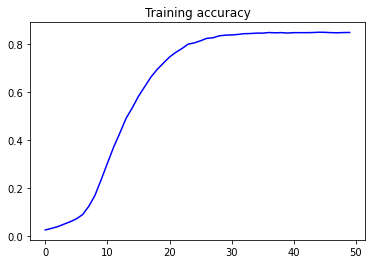

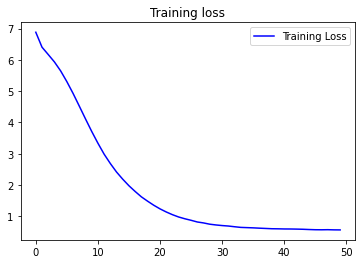

In [16]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [17]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope that thee doth have years told to figure ' hate me thee is so bold true time those tomb free green thee tongue bright are gone more forth so deeds to thee and thee bright prove thee more ' so long no delight end end night much than minds hid 'tis first art much gone again new alone are so near can can praise prove you than hate say so worthy of me well well lies seen thee releasing ' now third can lie so true why lovest did art beloved the part of my sight lies seen me '
